In [ ]:
# install environment
!pip install gymnasium==1.0.0 ale-py ipywidgets trace-opt autogen --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 642.5/642.5 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 115.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.2 MB/s eta 0:00:00


In [ ]:
import os
import ipywidgets as widgets
from IPython.display import display

# Function to save the environment variable and API key
def save_env_variable(env_name, api_key):
    # Validate inputs
    if not env_name.strip():
        print("⚠️ Environment variable name cannot be empty.")
        return
    if not api_key.strip():
        print("⚠️ API key cannot be empty.")
        return

    # Store the API key as an environment variable
    os.environ[env_name] = api_key
    globals()[env_name] = api_key  # Set it as a global variable
    print(f"✅ API key has been set for environment variable: {env_name}")

# Create the input widgets
env_name_input = widgets.Text(
    value="OPENAI_API_KEY",  # Default value
    description="Env Name:",
    placeholder="Enter env variable name (e.g., MY_API_KEY)",
)

api_key_input = widgets.Password(
    description="API Key:",
    placeholder="Enter your API key",
)

# Create the button to submit the inputs
submit_button = widgets.Button(description="Set API Key")

# Display the widgets
display(env_name_input, api_key_input, submit_button)

# Callback function for the button click
def on_button_click(b):
    env_name = env_name_input.value
    api_key = api_key_input.value
    save_env_variable(env_name, api_key)

# Attach the callback to the button
submit_button.on_click(on_button_click)

Text(value='OPENAI_API_KEY', description='Env Name:', placeholder='Enter env variable name (e.g., MY_API_KEY)'…

Password(description='API Key:', placeholder='Enter your API key')

Button(description='Set API Key', style=ButtonStyle())

✅ API key has been set for environment variable: OPENAI_API_KEY


In [ ]:
import gymnasium as gym
import pygame
import numpy as np
import ale_py
from opto.trace import node, bundle
import autogen
from opto.optimizers import OptoPrime
from opto import trace
from opto.trace.utils import render_opt_step
from collections import deque
import cv2
import openai
import matplotlib.pyplot as plt
from IPython.display import clear_output
import json
import re
import base64

Using LiteLLM as the default LLM backend.


In [ ]:
client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

ACTION_MAP = {
    "NOOP": 0,
    "UP": 1,
    "RIGHT": 2,
    "LEFT": 3,
    "DOWN": 4
}

REVERSE_ACTION_MAP = ["NOOP", "UP", "RIGHT", "LEFT", "DOWN"]

def call_LLM(frame_stack, pre_action, frog_pos):
    openai.api_key = os.getenv("OPENAI_API_KEY")
    prompt_text = """
    You are playing the Atari game **Frogger**. Your task is to control the frog across the **road and river** to reach the **safe empty spots** at the top of the screen.

    ### **Goal**
    - Move the frog **as close as possible** to the safe spots.
    - Reaching an **empty safe spot** at the top provides **more score**.
    - Avoid **obstacles** vehicles on the road, or **falling into the water** to **survive**.

    ### **Input**
    You will receive:
    1. **A NumPy array of 4 grayscaled frames** with shape **(4, 250, 160)**:
      - The **4th frame** (last in the array) is the **current frame**.
      - The **1st, 2nd, and 3rd frames** are **previous frames** at **timestep -3, -2, and -1**.
    2. The frog's **previous position** indicates the center of frog.
    3. The frog's **previous action**. Which is the action leads frog from previous position to the current position.

    ### **Actions You Can Take**
    Choose **one** of the following:
    - `"NOOP"` → Do nothing.
    - `"UP"` → Move the frog up.
    - `"LEFT"` → Move the frog left.
    - `"RIGHT"` → Move the frog right.
    - `"DOWN"` → Move the frog down.

    ### 1. Analyze the Current Frame (4th Frame)

    Identify the elements inside the frame:
    Game Border Area: Includes frog lives, time bar, and points.
    Game Screen Area: Contains two main regions:
    Road Section: Vehicles moving horizontally as obstacles.
    River Section: Floating obstacles (logs, turtles) moving horizontally.
    There are two safe lines separating the road and river.
    Each vehicle or obstacle varies in size and may occupy an m × n pixel space.
    ### 2. Locate the Frog in the Current Frame

    The frog is a 7 × 7 pixel cluster with a color distinct from the background.
    The frog does not move row by row but instead jumps a few rows at a time.
    In each move action, the frog typically jumps around 11 pixels forward.
    ### 3. Verify Frog Movement Using Previous Data

    You are given the previous frog position (center) and its last action.
    Check whether the frog has moved in the expected direction based on its last action.
    If the movement aligns with the expected behavior, update the frog’s position.
    If the movement does not match expectations, search for the next most probable frog position and update accordingly.
    The frog moves approximately 5-6 pixels per action, so ensure consistency with this behavior.
    ### 4. Identify the Goal Location

    The goal is to reach an empty safe spot at the top of the game screen.
    ### 5. Plan a Safe Path to the Goal

    Identify potential obstacles directly in front of the frog’s moving direction.
    Avoid moving directly into obstacles on the road or falling into the river.
    Use previous frames to track the speed and position of moving obstacles.
    Be aware of invisible obstacles in the frog’s row by estimating their positions from previous frames.
    If necessary, move in the same direction as floating obstacles to increase safety time in that row.
    ### Hints:

    1. Obstacle Prediction:
      - Some obstacles are not visible in the current frame, but you can predict their locations using previous frames.
    2. Moving Hazards:
      - Use previous frames to determine the speed of obstacles.
    3. Time Limit:
      - The game has a 100-frame limit before the frog dies.
    4. Frog Movement:
      - The frog does not move row by row; instead, it jumps a few rows at a time.
    5. Action Restrictions:
      - The same movement action (UP, LEFT, RIGHT, DOWN) cannot be executed twice in a row.
      - If you have UP as previous action, this time you can't use UP again

    ## **Expected Response Format (JSON)**
    Respond in **JSON format** with **two keys**:
    - `"action"` → The chosen action (`"NOOP"`, `"UP"`, `"LEFT"`, `"RIGHT"`, `"DOWN"`).
    - `"frog"`   → The position of the frog in the current 250*160 frame, which should be the same with frog prev location if the previous location is correct.
    - `"reason"` → A short explanation (~100 words) covering:
      - **Frog’s previous location, previous action and current location**
      - **Obstacle analysis**
      - **Justification for the chosen move**

    ### **Example Response**
    {
        "action": "RIGHT",
        "frog": [40, 80],
        "reason": "The frog is at (40, 70). The next row has a fast-moving car approaching from the left, making UP unsafe. There is an open lane on the right, and previous frames confirm it remains open for the next move. Moving RIGHT is the best choice to avoid danger and progress toward the goal."
    }
    """
    prompt_text += f"frame_stack: {frame_stack}, pre_action: {pre_action}, pre_forg: {frog_pos}"
    # Call OpenAI API
    response = client.chat.completions.create(
        model="gpt-4o",  # Choose GPT-4 or GPT-3.5
        messages=[{"role": "user", "content": prompt_text}],
        temperature=0.1  # Adjust creativity (lower = more deterministic)
    )
    cleaned_text = re.sub(r"```json|```", "", response.choices[0].message.content).strip()
    response_json = json.loads(cleaned_text)
    print(response_json["reason"])
    print(response_json["frog"])
    return ACTION_MAP[response_json["action"]], response_json["frog"]

In [ ]:
def call_LLM_image(image_path, previous_action, previous_image_path):
    # read images
    with open(image_path, "rb") as image_file:
        image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    with open(image_path, "rb") as image_file:
      pre_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    with open("./img/example.png", "rb") as image_file:
      example_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    # prepare prompt
    prompt_text = """
    You are playing the Atari game **Frogger**. Your task is to control the frog across the **road and river** to reach the **safe empty spots** at the top of the screen.

    ### **Goal**
    - Move the frog **as close as possible** to the safe spots.
    - Reaching an **empty safe spot** at the top provides **more score**.
    - Avoid **vehicles** on the road, or **falling into the water** to **survive**.

    ### **Input**
    You will receive:
    1. **Two images under (250, 160)**:
      - The **4th frame** (last in the array) is the **current frame**.
      - The **1st, 2nd, and 3rd frames** are **previous frames** at **timestep -3, -2, and -1**.
    2. The frog's **previous position** indicates the center of frog.
    3. The frog's **previous action**. Which is the action leads frog from previous position to the current position.

    ### **Actions You Can Take**
    Choose **one** of the following:
    - `"NOOP"` → Do nothing.
    - `"UP"` → Move the frog up.
    - `"LEFT"` → Move the frog left.
    - `"RIGHT"` → Move the frog right.
    - `"DOWN"` → Move the frog down.

    ### **Think Step by Step**
    1. Identify the current position of the green frog in the screenshot.
    2. Find the empty goal spot for the frog, there are five goal spots on the top of the screenshot, choose a cloest one for frog
    3. Select one action from the action space to reach the goal.
    4. According to the path you find, estimate the next position of frog. Is it safe? If not, back to step 3 and pick another action.
      - Based on the current frog's position, if frog's next position after your proposed moving action can hit vehicle or fall into water, then pick another action.


    ### **Hints**
    1. Time Limit
      - Each frog has about 100 time steps life so be quick!
    2. If previous action is one of the "UP", "LEFT", "RIGHT", "DOWN", you need to return "NOOP".
    3. Frog is safe staying on floating obstcles on the river. Before it can clearly jump on any objects on the next position of river, staying is safer option.

    ### **Expected Response Format (JSON)**
    Respond in **JSON format** with **two keys**:
      - `"action"` → The chosen action (`"NOOP"`, `"UP"`, `"LEFT"`, `"RIGHT"`, `"DOWN"`).
      - `"reason"` → A short explanation (~100 words) covering:
        - **Frog’s previous location, previous action and current location**
        - **Obstacle analysis**
        - **Justification for the chosen move**

    """

    prompt_text_pre = f"This is the previous screenshot and the previous action the frog took is: {previous_action}"
    # Make a request to OpenAI
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt_text},
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{image_base64}"}}                ],
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt_text_pre},
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{pre_image_base64}"}}
                ]
            }
            # ,
            # {
            #     "role": "user",
            #     "content": [
            #         {"type": "text", "text": "this is an example of a frog about to be hit by vehicle after the UP action"},
            #         {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{example_image_base64}"}}
            #     ]
            # }
        ],
        max_tokens=500
    )
    print(response.choices[0].message.content)
    match_text = re.search(r"```json\s*(\{.*?\})\s*```", response.choices[0].message.content, re.DOTALL)
    # cleaned_text = re.sub(r"```json|```", "", response.choices[0].message.content).strip()
    if not match_text:
        return ACTION_MAP["NOOP"]
    response_json = json.loads(match_text.group(1))
    print(response_json["reason"])
    return ACTION_MAP[response_json["action"]]


def call_LLM_confirm(image_path, action_name, previous_image_path):
    # read images
    with open(image_path, "rb") as image_file:
        image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    with open(image_path, "rb") as image_file:
      pre_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    # prepare prompt
    prompt_text = f"""
    In the game of Atari Frogger, the current screenshot is like this.
    Now frog is taking action: {action_name}
    To avoid hit by vehicle or fall into the water, is it safe to move {action_name}?

    ### **Expected Response Format (JSON)**

    Respond in **JSON format** with **three keys**:
      - `"Safe"` → The one word answer: YES or NO
      - `"action"` → The suggested different action (`"NOOP"`, `"UP"`, `"LEFT"`, `"RIGHT"`, `"DOWN"`) if {action_name} is NOT SAFE
      - `"reason"` → A short explanation
    Example:
    ```json
    {{
        `"Safe"`: `"YES"`,
        `"action"`: `"RIGHT"`,
        `"reason"`: `"The frog is at (40, 70)"`.
    }}```
    """
    print("Prompt: " + prompt_text)
    # Make a request to OpenAI
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt_text},
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{image_base64}"}}                ],
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "This is the screenshot 1 step before, use this to estimate the speed of moving vehicle and obstacles"},
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{pre_image_base64}"}}
                ]
            }
        ],
        max_tokens=500
    )
    print(response.choices[0].message.content)
    match_text = re.search(r"```json\s*(\{.*?\})\s*```", response.choices[0].message.content, re.DOTALL)
    # cleaned_text = re.sub(r"```json|```", "", response.choices[0].message.content).strip()
    if not match_text:
        return ACTION_MAP[action_name]
    response_json = json.loads(match_text.group(1))
    print(response_json["reason"])
    if response_json["Safe"] == "YES":
        return ACTION_MAP[action_name]
    else:
        return ACTION_MAP[response_json["action"]]


In [ ]:
client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
ACTION_MAP = {
    "NOOP": 0,
    "UP": 1,
    "RIGHT": 2,
    "LEFT": 3,
    "DOWN": 4
}
def call_LLM_TEXT(objects, frog_pos, pre_action, image_path):
    openai.api_key = os.getenv("OPENAI_API_KEY")
    # read images
    with open(image_path, "rb") as image_file:
        image_base64 = base64.b64encode(image_file.read()).decode("utf-8")


    prompt_text = """
    You are playing the Atari game **Frogger**. Your task is to control the frog across the **road and river** to reach the **safe empty spots** at the top of the screen.

    ### **Goal**
    - Move the frog **as close as possible** to the safe spots.
    - Reaching an **empty safe spot** at the top provides **more score**.
    - Avoid **vehicles** on the road, or **falling into the water** to **survive**.

    ### **Input**
    You will receive:
    1. **list of Objects**:
      - The list of objects in the game area, with keys "center", "width", "height", "x-speed", "y-speed". center is in the format of (x,y), x-speed and y-speed are the pixel changes per time step on coordinate x or y.
    2. Current position of frog, which is the center point of frog in the format of (x, y).
    3. Previous action the frog took.
    4. The screenshot of the current game frame.

    ### **Actions You Can Take**
    Choose **one** of the following:
    - `"NOOP"` → Do nothing.
    - `"UP"` → Move the frog up (x-10, y).
    - `"LEFT"` → Move the frog left (x, y-10).
    - `"RIGHT"` → Move the frog right (x, y+10).
    - `"DOWN"` → Move the frog down (x+10, y).

    ### **What you need to do**
    1. Find a path for the frog to reach the safe spots at the top.
    2. Simulate each possible move (UP, LEFT, RIGHT, DOWN).
    3. For each move, calculate the frog’s next position.
    4. For each object in the object list, checke whether there is a collison with frog:
        - collison happens when frog's center position with the width (7) and height (7) range, x-axis or y-axis overlaps with the object's center position plus its width or heigh.
        - Frog has a 7 width and 7 height
        - In the road area, you want to avoid the collision, in water area, you want collision.
    6. If the move results in no collision in road section or immediate collision in water section, then the move is safe, otherwise use another action.
    7. If there will be a collision on the road, try to jump to the opposite direction of the object's movement. If the object will have collision has negative y-speed, then move RIGHT, if the object will have collision has positive y-speed, then move LEFT.

    ### **Hints**
    1. Time Limit
      - Each frog has about 100 time steps life so be quick!
    2. If previous action is one of the "UP", "LEFT", "RIGHT", "DOWN", you need to follow a different action which is different than the previous action.
    3. Frog is safe staying on floating obstcles on the river. Before it can clearly jump on any objects on the next position of river, staying is safer option.
    4. Frog position x in (x, y), if x is smaller than 80 then frog is on river, otherwise frog is on land

    ### **Expected Response Format (JSON)**
    Respond in **JSON format** with **two keys**:
      - `"action"` → The chosen action (`"NOOP"`, `"UP"`, `"LEFT"`, `"RIGHT"`, `"DOWN"`).
      - `"reason"` → A short explanation (~100 words)
    """
    prompt_text += f"objects: {objects}, frog position: {frog_pos}, previous action: {pre_action}"

    print(f"our prompt is: {prompt_text}")
    # Call OpenAI API
    response = client.chat.completions.create(
        model="o3-mini",  # Choose GPT-4 or GPT-3.5
        messages=[
            # {
            #     "role": "user",
            #     "content": [
            #         {"type": "text", "text": "Here is the screenshot of the current game frame, take an overview"},
            #         {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{image_base64}"}}
            #     ],
            # },
            {"role": "user", "content": prompt_text}
        ]
    )
    # print(f"Response: {response.choices[0].message.content}")
    # match_text = re.search(r"Response: \s*(\{.*?\})\s*```", response.choices[0].message.content, re.DOTALL)
    # if not match_text:
    #     print("unreadable format")
    #     return ACTION_MAP["NOOP"], "1111", "2222"
    response_json = json.loads(response.choices[0].message.content)


    return ACTION_MAP[response_json["action"]], response_json["reason"], prompt_text

In [ ]:
from scipy.ndimage import label, find_objects
import math


def prepare_frame(obs):
    gray_frame = cv2.cvtColor(obs, cv2.COLOR_BGR2GRAY)
    # try not resize first
    return gray_frame[13:-30, 8:-8]

def extract_objects(screen):

    background_values = [57, 0, 185]

    binary_mask = ~np.isin(screen, background_values)
    # Threshold the image: Convert to binary (objects vs. background)

    # Find connected components
    labeled_image, num_objects = label(binary_mask)
    # for i in range(len(labeled_image)):
    #   for j in range(len(labeled_image[0])):
    #     print(labeled_image[i][j], end=" ")
    #   print()
    # print(num_features)
    # Count object sizes
    object_slices = find_objects(labeled_image)
    objects_info = []

    for obj_idx, obj_slice in enumerate(object_slices):
        if obj_slice is None:
            continue

        # Get bounding box coordinates
        ymin, ymax = obj_slice[0].start, obj_slice[0].stop
        xmin, xmax = obj_slice[1].start, obj_slice[1].stop

        # Compute width and height
        width = xmax - xmin
        height = ymax - ymin

        # Compute center position
        center_x = xmin + width // 2
        center_y = ymin + height // 2

        # Ignore objects smaller than min_size
        if width * height >= 5:
            objects_info.append({
                "center": (center_y, center_x),
                "width": width,
                "height": height
            })
    # print objects and their values
    # for obj in objects_info:
    #     for i in range(obj["center"][0] - obj["height"]//2, obj["center"][0] + obj["height"]//2):
    #         for j in range(obj["center"][1] - obj["width"]//2, obj["center"][1] + obj["width"]//2):
    #           print(screen[i][j], end=" ")
    #         print()
    #     print()
    #     print()


    return objects_info

def calculate_init_speed(objects_info1, frog_pos):
    objects = []
    # track non-frog objects
    for i in range(len(objects_info1)):
        if abs(objects_info1[i]["center"][0] - frog_pos[0]) > 0 or abs(objects_info1[i]["center"][1] - frog_pos[1]) > 0:
            objects.append({
                "center": objects_info1[i]["center"],
                "width": objects_info1[i]["width"],
                "height": objects_info1[i]["height"],
                "x-speed": 0,
                "y-speed": 0
            })
    return objects

def calculate_cur_speed(objects, objects_info, frog_pos):
    # update objects:
    for obj in objects:
        obj["center"] = (obj["center"][0] + obj["x-speed"], obj["center"][1] + obj["y-speed"])
        if obj["center"][0] < 0 or obj["center"][0] > 210 or obj["center"][1] < 0 or obj["center"][1] > 160:
            objects.remove(obj)


    for obj in objects_info:
        if obj["center"] == frog_pos:
            continue
        # check if obj in cur frame shows up in previous objects list
        find_flag = False
        for pre_obj in objects:
            if abs(obj["center"][0] - pre_obj["center"][0]) + abs(obj["center"][1] - pre_obj["center"][1]) < 5:
                if pre_obj["center"] != obj["center"]:

                    pre_obj["x-speed"] = obj["center"][0] - pre_obj["center"][0]
                    pre_obj["y-speed"] = obj["center"][1] - pre_obj["center"][1]
                    pre_obj["center"] = obj["center"]
                find_flag = True
        if not find_flag:
            objects.append({
                "center": obj["center"],
                "width": obj["width"],
                "height": obj["height"],
                "x-speed": 0,
                "y-speed": 0
            })
    return objects

def find_frog(objects_info, screen):
    for obj in objects_info:
        if obj["width"] == 7 and obj["height"] == 7 and screen[obj["center"][0]][obj["center"][1]] == 124:
            return obj["center"]
    return None

def partial_objects(objects, frog_pos):
    new_objects = []
    for obj in objects:
        if abs(obj["center"][0] - frog_pos[0]) + abs(obj["center"][1] - frog_pos[1]) < 50:
            new_objects.append(obj)
    return new_objects

frame_stack = deque(maxlen=4)


def stack_frames(frame_stack, new_frame):
    frame_stack.append(new_frame)  # Add new frame to the stack
    stacked_obs = np.stack(frame_stack, axis=0)  # Convert deque to NumPy array
    return stacked_obs


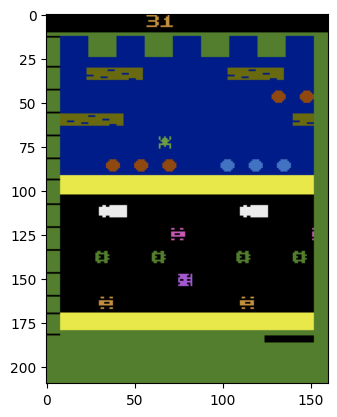

our prompt is: 
    You are playing the Atari game **Frogger**. Your task is to control the frog across the **road and river** to reach the **safe empty spots** at the top of the screen.

    ### **Goal**
    - Move the frog **as close as possible** to the safe spots.
    - Reaching an **empty safe spot** at the top provides **more score**.
    - Avoid **vehicles** on the road, or **falling into the water** to **survive**.

    ### **Input**
    You will receive:
    1. **list of Objects**:
      - The list of objects in the game area, with keys "center", "width", "height", "x-speed", "y-speed". center is in the format of (x,y), x-speed and y-speed are the pixel changes per time step on coordinate x or y.
    2. Current position of frog, which is the center point of frog in the format of (x, y).
    3. Previous action the frog took.
    4. The screenshot of the current game frame.

    ### **Actions You Can Take**
    Choose **one** of the following:
    - `"NOOP"` → Do nothing.
    - 

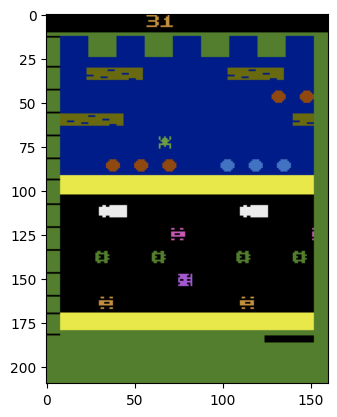

In [ ]:
REVERSE_ACTION_MAP = ["NOOP", "UP", "RIGHT", "LEFT", "DOWN"]
import os
import random

# transfer env frame into grayscale and test with LLM
env = gym.make("ALE/Frogger-v5", render_mode="rgb_array", mode=0)

for episode in range(10):
    obs, info = env.reset()
    trajactory = []
    prompt_all = ""
    # timestep random started from 100 to 120
    timestep = random.randint(100, 120)
    initial_timestep = timestep
    for _ in range(timestep):
        pre_obs = obs
        obs, reward, terminated, truncated, info = env.step(0)
        stacked_state = stack_frames(frame_stack, prepare_frame(obs))

    # timestep = 110
    # extract objects
    cur_objects = extract_objects(prepare_frame(obs))

    frog_pos = find_frog(cur_objects, prepare_frame(obs))
    objects = calculate_init_speed(cur_objects, frog_pos)
    # print(frog_pos)
    pre_action = 0

    running = True
    while running:
        # display the screenshot
        img = env.render()
        plt.imshow(img)
        clear_output(wait=True)
        display(plt.gcf())

        # store the screenshot
        plt.imsave(f"./frogger/frogger_{timestep}.png", img)

        # current objects and their coordinates
        cur_objects = extract_objects(prepare_frame(obs))
        frog_pos = find_frog(cur_objects, prepare_frame(obs))
        objects = calculate_cur_speed(objects, cur_objects, frog_pos)
        if frog_pos is not None:
            action, prompt, reason = call_LLM_TEXT(partial_objects(objects, frog_pos), frog_pos, REVERSE_ACTION_MAP[pre_action], f"./frogger/frogger_{timestep}.png")
        else:
            action = 0
            reason = "Frog died, waiting..."
            prompt = ""
        prompt_all += f"Our prompt: \n{prompt}\n{reason}\n\n"
        # screen = prepare_frame(obs)

        # for a in range(len(screen)):
        #     for b in range(len(screen[0])):
        #         print(screen[a][b], end=" ")
        #     print()

        # for obj in objects:
        #     print(obj)
        #     for i in range(obj["center"][0] - obj["height"]//2, obj["center"][0] + obj["height"]//2):
        #         for j in range(obj["center"][1] - obj["width"]//2, obj["center"][1] + obj["width"]//2):
        #             print(screen[i][j], end=" ")
        #         print()
        #     print()
        #     print()
        # x = input()

        obs, reward, terminated, truncated, info = env.step(action)
        next_stacked_state = stack_frames(frame_stack, prepare_frame(obs))
        trajactory.append((stacked_state, action, reward, next_stacked_state, terminated))

        stacked_state = next_stacked_state
        pre_action = action

        if terminated or truncated:
            obs, info = env.reset()
            break

        timestep += 1


    os.system(f"ffmpeg -framerate 5 -start_number {initial_timestep} -i frogger/frogger_%03d.png -vcodec mpeg4 -y movie_{episode}.mp4")

    # save trajectory
    trajectory_np = np.array([(s, a, r, ns, terminated) for s, a, r, ns, terminated in trajactory], dtype=object)
    np.save(f"trajectory_{episode}.npy", trajectory_np)
    # save prompt and answer
    with open(f"prompt_{episode}.txt", "w") as f:
        f.write(prompt_all)


In [ ]:
os.system(f"ffmpeg -framerate 5 -start_number 110 -i frogger/frogger_%03d.png -vcodec mpeg4 -y movie_{episode}.mp4")



0

In [ ]:
# Here is the 4 grayscale frames (250*160) indicating Atari game Frogger from time 1 to time 4, in the frame there are two main areas: 1. game boarders containing game score, remaining lives, game score and remaining time. 2. game contents, which includes river section on the top and road section on the bottom, with two safe belts. In the river section, there are obstacles floating on the river, moving horizontally. In the road section, there are also vehicles moving horizontally. Each obstacles and vehicles are represented in cluster of pixels distinct from background. The most import is the frog. When game started, the frog is sitting in the middle of bottom safe belt right under road section, frog is represented as a 7*7 cluster of pixels.
# Give the 4 frames in time sequence, frog is not moving, vehicles and obstacles are moving horizontally, can you locate the frog and return its central position?

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 125, 125, 125, 125, 125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
def init_LLM():
    openai.api_key = os.getenv("OPENAI_API_KEY")
    prompt_text = """
    ### Frogger Frame Analysis Task

    You are analyzing 4 grayscale frames (210 × 160) from the Atari game Frogger, taken sequentially from time 1 to time 4.

    Frame Structure:
    Each frame consists of two main areas:

    Game Borders (HUD elements): Displays the game score, remaining lives, points, and time.
    Game Contents (playable area):
    River Section (Top): Contains floating obstacles (logs, turtles) moving horizontally.
    Road Section (Bottom): Contains moving vehicles traveling horizontally.
    Two safe belts separate the river and road.
    Frog Characteristics & Movement:
    The frog is represented as a 7 × 7 cluster of pixels with a distinct color from the background.
    At the start of the game, the frog is positioned in the middle of the bottom safe belt, directly under the road section.
    The frog does not move in these 4 frames, but vehicles and obstacles do.
    Task:
    Locate the exact central position of the frog in the 4th frame.
    The expected return format: [x, y] (where x and y are the frog's pixel coordinates).

    """
    # Call OpenAI API
    prompt_text += f"frames_stack: {frames}"
    response = client.chat.completions.create(
        model="gpt-4o",  # Choose GPT-4 or GPT-3.5
        messages=[{"role": "user", "content": prompt_text}],
        temperature=0.1  # Adjust creativity (lower = more deterministic)
    )
    return response.choices[0].message.content
print(init_LLM())

To locate the exact central position of the frog in the 4th frame, we need to analyze the given frames and identify the distinct 7 × 7 cluster of pixels that represents the frog. Since the frog is stationary across these frames, its position should remain constant.

Given the structure of the frames, the frog starts in the middle of the bottom safe belt, directly under the road section. The bottom safe belt is likely located near the bottom of the frame, just above the consistent pixel values (97 in this case) that represent the game borders or HUD elements.

Here's a step-by-step approach to find the frog's position:

1. **Identify the Safe Belt Area**: The bottom safe belt is located just above the consistent pixel values (97) at the bottom of the frame. We need to search for the frog in this area.

2. **Locate the Frog**: The frog is a distinct 7 × 7 cluster of pixels. We need to find a cluster of pixels that stands out from the background in the bottom safe belt area.

3. **Determi

In [ ]:
obs, info = env.reset()
SIZE = 48
frame_stack = deque(maxlen=4)
action_stack = deque(maxlen=3)

def prepare_small_frame(obs):
    gray_frame = cv2.cvtColor(obs, cv2.COLOR_BGR2GRAY)
    resized_frame = cv2.resize(gray_frame, (SIZE, SIZE))
    # try not resize first
    return resized_frame
for _ in range(110):
    obs, reward, terminated, truncated, info = env.step(0)
    actions = stack_everything(action_stack, 0)
    frames = stack_everything(frame_stack, prepare_small_frame(obs))

for i in range(len(frames[3])):
    for j in range(len(frames[3][0])):
        print(frames[3][i][j], end=" ")
    print()

# print(frames.tolist())
# np.save("frames.npy", frames)


0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 39 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 
97 97 63 57 57 57 57 97 97 97 97 97 57 57 57 57 57 97 97 97 97 90 57 57 57 57 90 97 97 97 97 57 57 57 57 57 97 97 97 97 97 57 57 57 57 63 97 97 
97 97 63 57 57 57 57 97 97 97 97 97 57 57 57 57 57 97 97 97 97 90 57 57 57 57 90 97 97 97 97 57 57 57 57 57 97 97 97 97 97 57 57 57 57 63 97 97 
97 97 64 57 57 57 57 97 97 97 97 97 57 57 57 57 57 97 97 97 97 90 57 57 57 57 90 97 97 97 97 57 57 57 57 57 97 97 97 97 97 57 57 57 57 64 97 97 
97 97 63 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 63 97 97 
97 97 64 57 57 78 78 78 78 63 78 78 78 78 78 57 57 57 57 57 57 57 57 57 57 57 57

[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 92, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 97, 122, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 122, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

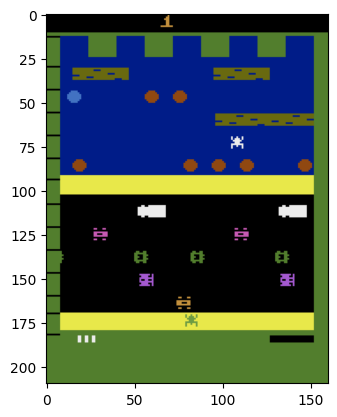

In [ ]:
# os.system("ffmpeg -i v/%01d.png -vcodec mpeg4 -y movie.mp4")
obs, info = env.reset()

for _ in range(110):
    obs, reward, terminated, truncated, info = env.step(0)
    frames = stack_everything(frame_stack, prepare_frame(obs))

print(frames.tolist())
img = env.render()
plt.imshow(img)

In [ ]:
import base64
image_path = "1.png"
with open(image_path, "rb") as image_file:
    image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

# Make a request to OpenAI
response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Where is the green frog in this image?"},
                {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{image_base64}"}}
            ],
        }
    ],
    max_tokens=300
)

# Print response
print(response.choices[0].message.content)

TypeError: 'ChatCompletion' object is not subscriptable

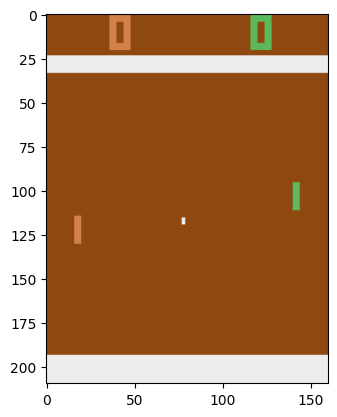

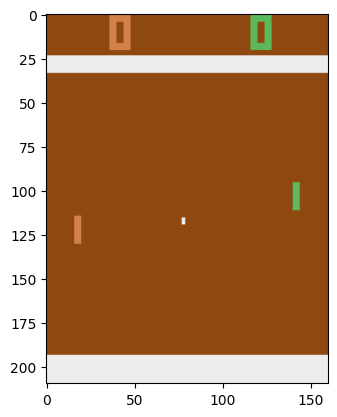

In [ ]:
for _ in range(10):
    obs, reward, terminated, truncated, info = env.step(0)
    img = env.render()
    plt.imshow(img)
    clear_output(wait=True)
    display(plt.gcf())
